# Processing real text (from out on the inter-webs)

**Exercise 1 Preprocessing the ZeldaWiki text. Follow the bullets below for each character in your character list:**

* Read the file containing the character's page description.
* Filter out the headers of sections by using re.sub(pattern,'',DESCRIPTION_HERE) (hint headers are in the form == header name == where the number of = might vary.
    * Note: I found that there are many repetitions towards the end of pages in the sections "Locations", "Nomenclature", "See Also", and "Gallery". You can remove these sections from the description entirely (up to you).
* Tokenize your text with WordPunctTokenizer()
* Exclude characters names (since we're interested in the words, not the names)
    * Note 1 some of our characters have names that are made by multiple words, e.g., "Mo'a Keet", thus you might want to exclude these before tokenizing
    * Note 2 common enemy names can appear with Upper-, Lower-case, and plural forms, e.g., Bokoblin, bokoblin, bokoblins. It is up to you to decide whether you want to take care of these cases.
* Exclude punctuation and stop words.
* Set everything to lower case.
* Lemmatize your words with WordNetLemmatizer()
* Save your output for future use.

Note none of the above has to be perfect. It might not be easy to remove all characters names. And there's some room for improvisation. In my own first run the results didn't look so nice, because some pages are very detailed and might contain lists of words as the one in the "See Also" section, whereas other pages are very short. For that reason, I added a few notes for you on how I decided to handle some of these cases. You could also choose to use the unique set of words from each page rather than each word in proportion to how it's actually used on that page for instance (there are pros and cons with both choices). Choices like that are up to you.

In [24]:
import pandas as pd
import re
import os
import urllib.request
import json
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
import nltk
import matplotlib.pyplot as plt
from collections import Counter

In [27]:
df_characters = pd.read_csv('ZeldaBotW_nodes_w_attributes_enriched.txt')

In [28]:
df_characters.head()

,Name,Role,Race,Gender
0,Baddek,Ally,Hylian,Male
1,Bamboo,Ally,Horse,Unknown
2,Banji,Ally,Hylian,Female
3,Baumar,Ally,Hylian,Male
4,Bayge,Ally,Goron,Male


In [34]:
path = 'characters_clean_text/'

In [35]:
# get list of all the names before I want to remove it from my content
normal_name = []
comp_name = []
list_of_names = df_characters['Name'].tolist()
for name in list_of_names:
    if ' ' in name:
        comp_name.append(name)
    else:
        normal_name.append(name)

In [38]:
from tqdm.notebook import tqdm

final_list = []
for char in tqdm(list(df_characters['Name'].values)):
    
    with open(path + char + '.txt', 'r', encoding="utf-8") as file:
        content = file.read()
    
    char = char.replace(' ','_')
    pattern = r'\=+[\w\s]+\=+'
    new_line_pattern = r'\\n'
    new_content = re.sub(pattern, '', content)
    new_content = re.sub(new_line_pattern, ' ', content)
    
    # hér remove-a composite names -> áður en við tonkenizum
    for name in comp_name:
        new_content = new_content.replace(name, "")
        
    tk = RegexpTokenizer(r'\w+') # nota þennan tokenizer til þess að geta removeað punktuation á auðveldan hátt
    token_content = tk.tokenize(new_content)
    
    # hér remove-a normal names
    words = [word for word in token_content if word not in normal_name]
    
    # remove-a stop words
    words = [word for word in words if word not in stopwords.words('english')]
    
    # setja allt i lower case
    words = [word.lower() for word in words]
    
    wnl = WordNetLemmatizer()
    words = [wnl.lemmatize(word) for word in words]
    
    final_list.extend(words)

**Exercise 2 Frequency distribution. Now that we have preprocess the ZeldaWiki pages:**

join them all together and convert them with nltk.Text()
use your code from Week 6, to create frequency distribution including the cumulative frequency plot for the 75 most common words.
How does your new distribution differ from the one you found in Week 6?

In [39]:
text = Text(final_list)

In [40]:
fd = nltk.FreqDist(text)

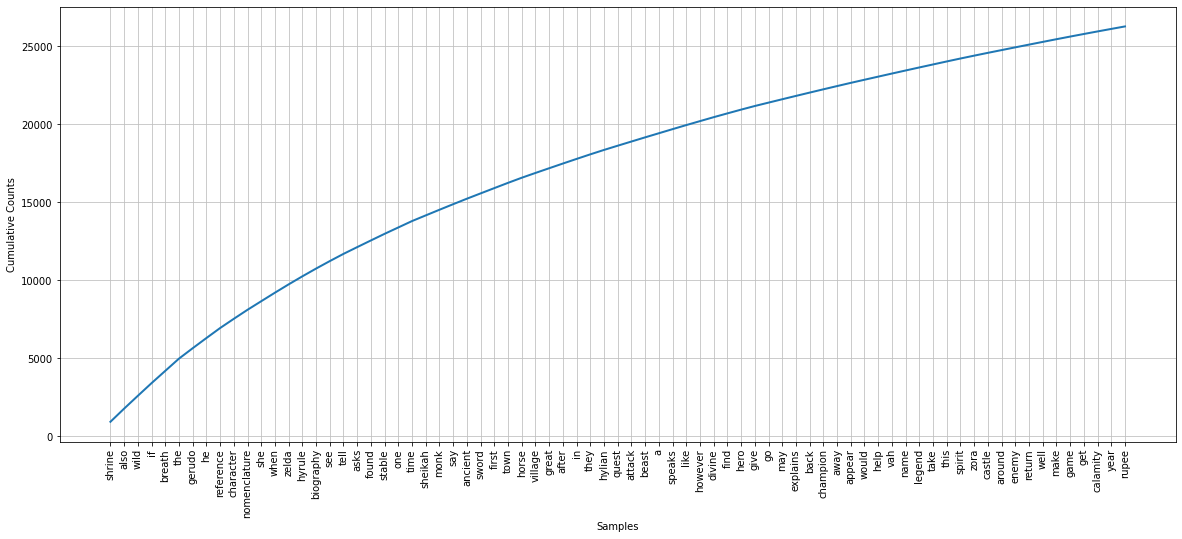

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [41]:
plt.figure(figsize=(20, 8))
fd.plot(75, cumulative=True) # cumulative telur öll orðin upp, þetta er semi intervalið af neðri myndinni

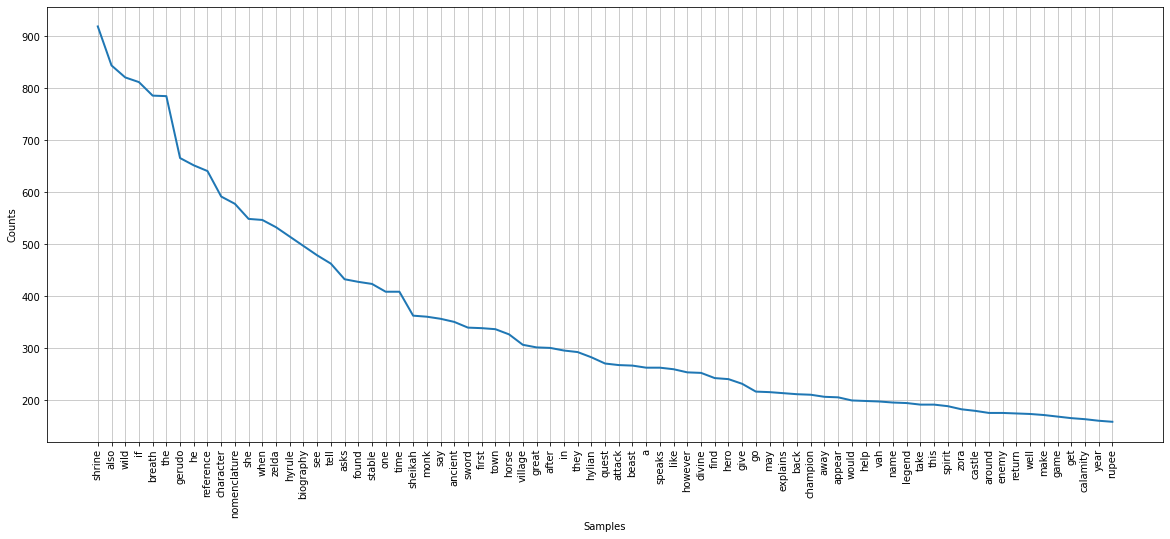

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [42]:
plt.figure(figsize=(20, 8))
fd.plot(75)

# Words that characterize the characters

**Exercise 3: TF-IDF and the characters' race.**

* Check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF.
    * What does TF stand for?
    * What does IDF stand for?
* Since we want to find out which words are important for each race, we're going to create one document per race in BotW. Thus, combine the ZeldaWiki pages into one long list per race.
* Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each race.
    * Describe similarities and differences between races.
    * Even though some terms might be descriptive, why are TFs not necessarily a good description of the races?
* Next, we calculate IDF for every word.
    * What base logarithm did you use? Is that important?
* We're ready to calculate TF-IDF. Do that for each race.
    * List the 5 top words for each race.
    * Are these 5 words more descriptive of the race? If yes, what is it about IDF that makes the words more informative?
* Normally, TF-IDF is used for single documents. What does TF-IDF tell us about the content of a single document in a collection.

> TF: term frequency

> IDF: inverse document frequency

> It is intended to reflect how important a word is in a document or a corpus. The tf–idf value increases proportionally to the number of times a word appears in the document 

In [11]:
race_list = list(set(df_characters['Race']))

In [43]:
dict_of_races = {}
for race in race_list:
    final_list = []
    df = df_characters[df_characters['Race'] == race] # svo ég þurfi ekki að loopa í gegnum allt, heldur bara þegar name samsvarar raceinu sem ég er staðsett í
    for char in df['Name']:
        
        with open(path + char + '.txt', 'r', encoding="utf-8") as file:
            content = file.read()
        
        char = char.replace(' ','_')    
        pattern = r'\=+[\w\s]+\=+'
        new_line_pattern = r'\\n'
        new_content = re.sub(pattern, '', content)
        new_content = re.sub(new_line_pattern, ' ', content)
    
        # hér remove-a composite names -> áður en við tonkenizum
        for name in comp_name:
            new_content = new_content.replace(name, "")
        
        tk = RegexpTokenizer(r'\w+') # nota þennan tokenizer til þess að geta removeað punktuation á auðveldan hátt
        token_content = tk.tokenize(new_content)
    
        # hér remove-a normal names
        words = [word for word in token_content if word not in normal_name]
    
        # remove-a stop words
        words = [word for word in words if word not in stopwords.words('english')]
    
        # setja allt i lower case
        words = [word.lower() for word in words]
    
        wnl = WordNetLemmatizer()
        words = [wnl.lemmatize(word) for word in words]
        
        final_list.extend(words) # passa að yfirskrifa ekki!!!
    dict_of_races[race] = final_list

In [44]:
len(dict_of_races['Hylian'])

34059

In [45]:
# finna 5 most common
most_common_dict = {}
for key, val in dict_of_races.items():
    c = Counter(val)
    most_common = c.most_common(5)
    most_common_dict[key] = most_common

In [46]:
# the number of times a word appears in a document, divided by the total number of words in that document
# calculate the TF for each word
# ná í unique list með öllum oðrunum, og fyrir hvert orð i listanum telja hvað það kemur oft fyrir i hverju race-i
word_list = []
for key, val in dict_of_races.items():
    word_list.extend(val)
unique_word_list = list(set(word_list))

In [47]:
TF_dict = {} # dictionary sem telur hversu oft hvert of eitt orð kemur fyrir
for key, val in dict_of_races.items():
    word_count = []
    for word in unique_word_list:
        count = 0
        for i in val:
            if word == i:
                count += 1
        word_count.append(count)
    TF_dict[key] = word_count

In [48]:
TF_dict['Unknown']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [49]:
sum_of_races = {}
for race in race_list:
    for i in range(len(TF_dict)):
        sum_of_races[race] = sum(TF_dict[race])

In [50]:
sum_of_races

{'Gerudo': 12183,
 'Hinox': 1460,
 'Unknown': 1829,
 'Horse': 1010,
 'Keese': 2107,
 'Goron': 4060,
 'Dragon': 299,
 'Moblin': 2128,
 'Guardian': 1318,
 'Korok': 1022,
 'Sand Seal': 67,
 'Talus': 1285,
 'Hylian': 34059,
 'Rito': 4222,
 'Lynel': 1131,
 'Bokoblin': 1758,
 'Wizzrobe': 684,
 'Human': 867,
 'Lizalfos': 978,
 'Dog': 87,
 'Great Fairy': 448,
 'Sheikah': 13144,
 'Zora': 4163,
 'Octorok': 834,
 'Chuchu': 2338,
 'Molduga': 320,
 'Ancient Orb': 37}

In [59]:
calculate_TF = {}
for race in tqdm(race_list):
    #for i in range(len(TF_dict)):
        for count in TF_dict[race]:
            if race in calculate_TF:
               calculate_TF[race].extend([count/sum(TF_dict[race])])
            else:
               calculate_TF[race] =  [count/sum(TF_dict[race])]

In [66]:
calculate_TF

{'Gerudo': [0.0,
  8.208158909956496e-05,
  0.00016416317819912992,
  0.0,
  0.0,
  8.208158909956496e-05,
  0.00016416317819912992,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00016416317819912992,
  0.0,
  8.208158909956496e-05,
  8.208158909956496e-05,
  0.00016416317819912992,
  0.0,
  0.0,
  0.0,
  0.0012312238364934746,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00016416317819912992,
  0.002380366083887384,
  0.0008208158909956497,
  0.0,
  0.0,
  8.208158909956496e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00016416317819912992,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  8.208158909956496e-05,
  0.0,
  0.0,
  0.006402363949766067,
  8.208158909956496e-05,
  0.0,
  8.208158909956496e-05,
  0.0,
  0.0002462447672986949,
  0.0,
  0.0,
  8.208158909956496e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0010670606582943445,
  0.0,
  0.0,
  0.0,
  8.208158909956496e-05,
  8.208158909956496e-05,
  0.0009849790691947797,
  0.0,
  0.0,
 

In [67]:
IDF_list = []
for w in unique_word_list:
    count = 0
    for key, val in dict_of_races.items():
        if w in val:
            count += 1
    IDF_list.append(count)


In [73]:
import math
IDF = []
for n in IDF_list:
    IDF.append(math.log(len(TF_dict)/(n + 1)))

In [74]:
IDF

[2.6026896854443837,
 2.1972245773362196,
 1.9095425048844386,
 2.6026896854443837,
 2.6026896854443837,
 2.1972245773362196,
 1.5040773967762742,
 2.6026896854443837,
 2.6026896854443837,
 2.1972245773362196,
 2.6026896854443837,
 2.1972245773362196,
 2.6026896854443837,
 2.1972245773362196,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 1.6863989535702288,
 2.1972245773362196,
 0.5232481437645479,
 2.6026896854443837,
 1.9095425048844386,
 2.1972245773362196,
 2.6026896854443837,
 2.6026896854443837,
 0.46262352194811296,
 2.6026896854443837,
 2.1972245773362196,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 2.6026896854443837,
 1.5040773967762742,
 0.6567795363890705,
 1.349926716949016,
 2.6026896854443837,
 1.5040773967762742,
 1.9095425048844386,
 1.6863989535702288,
 2.1972245773362196,
 2.1972245773362196,
 1.9095425048844386,
 1.0986122886681098,
 2.1972245773362196,
 2.6026896854

In [75]:
calculate_IDF = {}

for i, word in enumerate(unique_word_list):  
    calculate_IDF[word] = IDF[i]
    

In [76]:
calculate_IDF

{'launched': 2.6026896854443837,
 'reminder': 2.1972245773362196,
 'offended': 1.9095425048844386,
 'experimentation': 2.6026896854443837,
 'promptly': 2.6026896854443837,
 'erratically': 2.1972245773362196,
 'agreeing': 1.5040773967762742,
 'gongoron': 2.6026896854443837,
 'motivated': 2.6026896854443837,
 'aboard': 2.1972245773362196,
 'evaporates': 2.6026896854443837,
 'carved': 2.1972245773362196,
 'behaves': 2.6026896854443837,
 'everywhere': 2.1972245773362196,
 'passersby': 2.6026896854443837,
 'consist': 2.6026896854443837,
 'campaign': 2.6026896854443837,
 'privileged': 2.6026896854443837,
 'retsam': 2.6026896854443837,
 'miniblins': 2.6026896854443837,
 'requested': 1.6863989535702288,
 'torso': 2.1972245773362196,
 'shoot': 0.5232481437645479,
 'indebted': 2.6026896854443837,
 'playable': 1.9095425048844386,
 'passionate': 2.1972245773362196,
 'witch': 2.6026896854443837,
 'courser': 2.6026896854443837,
 'ancient': 0.46262352194811296,
 'tct': 2.6026896854443837,
 'conductin